In [1]:
'''Examination of the variance in the likelihood estimate of the particle filter for varying number of particles N with the Toy example 
in section 16.5.1 on Introduction to SMC By Chopin and Papaspiliopoulos.'''

import numpy as np
import matplotlib.pyplot as plt

from particle_filter import filter
from pmcmc import PMCMC
from models import AR_model,AR_PMCMC_model
from scipy.stats import norm,uniform,gamma

In [2]:
rng = np.random.default_rng(0)

'''Model'''

model_params = {'rho':0.9,'sigma_x':1.,'sigma_y':1.2}

T = 300

X = np.zeros((T,))
X[0] = 0. 

Y = np.zeros((T,))
Y[0] = 0. 


for t in range(1,T): 
    X[t] = model_params['rho'] * X[t-1] + rng.normal(0,model_params['sigma_x'])
    Y[t] = X[t] + rng.normal(0,model_params['sigma_y'])


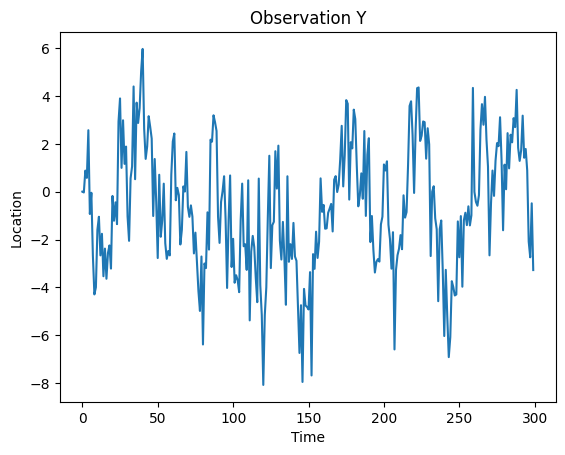

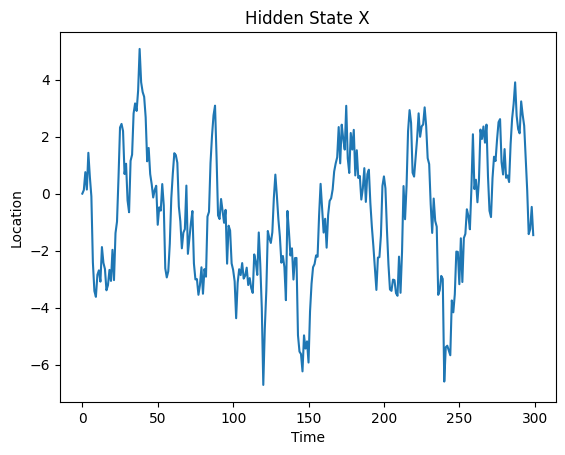

In [3]:
plt.title("Observation Y")
plt.ylabel('Location')
plt.xlabel('Time')
plt.plot(Y)
plt.show()

plt.title("Hidden State X")
plt.ylabel('Location')
plt.xlabel('Time')
plt.plot(X)
plt.show()

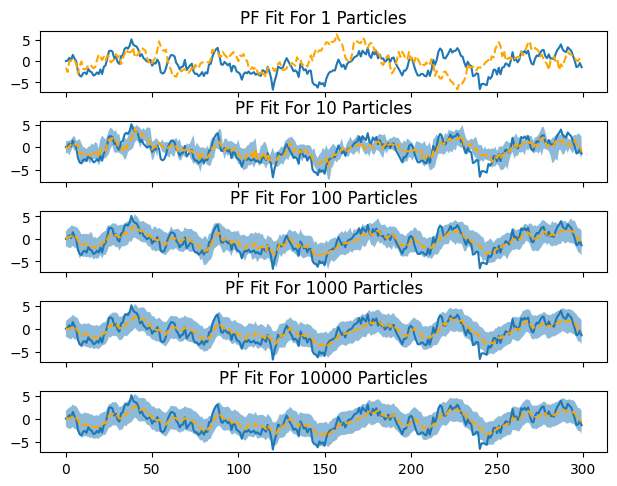

In [4]:
'''PF fit for 100 particles'''
fig, ax = plt.subplots(5, 1, sharex=True)
fig.tight_layout()

num_particles_list = [1,10,100,1000,10_000]

for i,num_particles in enumerate(num_particles_list):

    particles,weights,likelihood = filter(Y,theta = (model_params['rho'],model_params['sigma_x'],model_params['sigma_y']),dt = 1,rng = rng, model = AR_model,num_particles=num_particles,model_dim = 1)

    ax[i].set_title(f"PF Fit For {num_particles} Particles")
    ax[i].plot(np.arange(0,T),np.average(particles[:,0,:],weights = weights,axis = 0),'--',color = 'orange',zorder = 12)
    ax[i].plot(X)
    ax[i].fill_between(np.arange(0,T),np.percentile(particles[:,0,:],5,axis = 0),np.percentile(particles[:,0,:],95,axis = 0),alpha = 0.5)

Statistics for 1 particles:
Variance is 253.9660778763659 and mean is -821.7681401749096
Statistics for 10 particles:
Variance is 0.8709453291779419 and mean is -728.3898594281385
Statistics for 100 particles:
Variance is 0.4253019274535097 and mean is -724.9156394886553
Statistics for 1000 particles:
Variance is 0.10222276653943181 and mean is -725.1256913674105
Statistics for 10000 particles:
Variance is 0.001821609812005871 and mean is -725.1213127197218


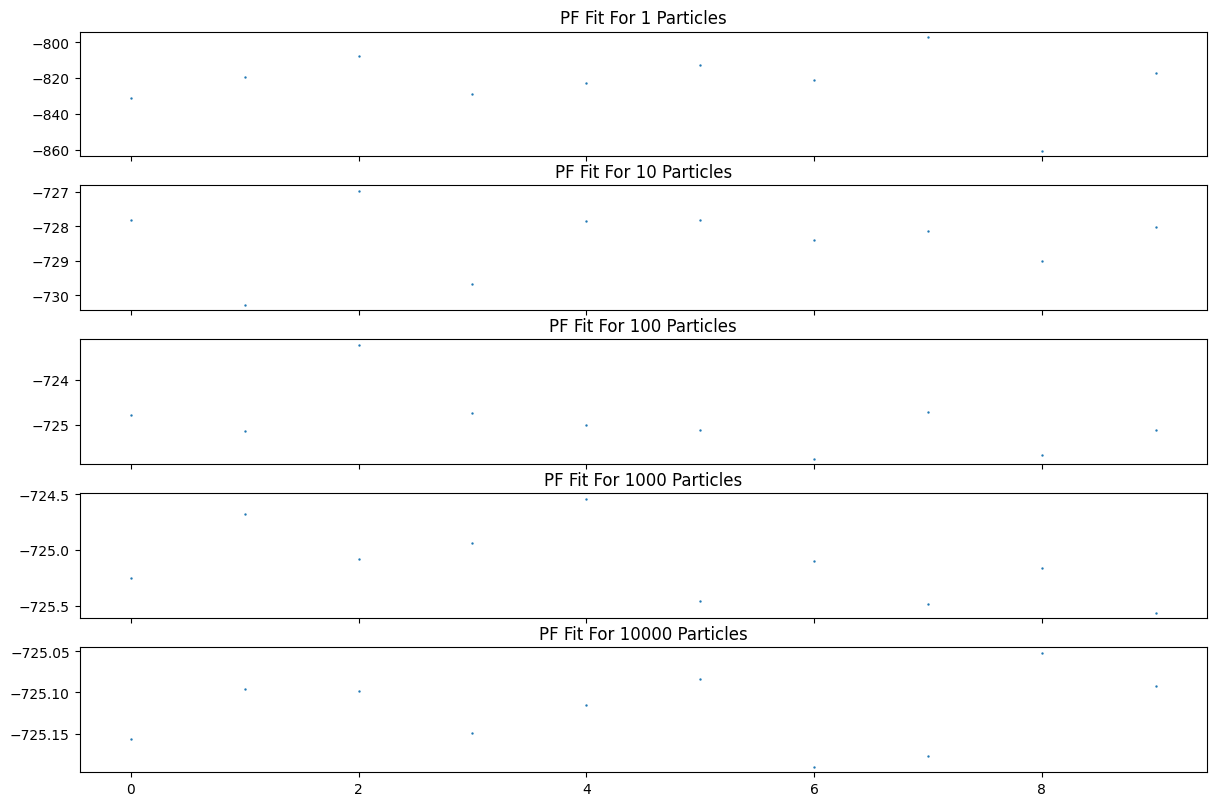

In [5]:
iterations = 10
num_particles = [1,10,100,1000,10_000]

fig, ax = plt.subplots(5, 1, sharex=True,figsize = (12,8))
fig.tight_layout()

for i in range(len(num_particles)):
    LL_s = []
    for iter in range(iterations):
        *_,likelihood = filter(Y,theta = (model_params['rho'],model_params['sigma_x'],model_params['sigma_y']),dt = 1,rng = rng, model = AR_model,num_particles=num_particles[i],model_dim = 1)
        LL_s.append(np.sum(np.log(likelihood)))


    ax[i].set_title(f"PF Fit For {num_particles[i]} Particles")
    ax[i].scatter(np.arange(0,iterations,1),LL_s,s=0.5)

    print(f"Statistics for {num_particles[i]} particles:")
    print(f"Variance is {np.var(LL_s)} and mean is {np.mean(LL_s)}")






### <center> Likelihood Computation Using the Kalman Filter

The Hidden Markov Model is defined as follows. A latent process is given where $A \in \mathbb{R}^{p \times k}$ and $F \in \mathbb{R}^{k \times k}$ and 
$v_t,w_t$ are vectors of parameterized Gaussian noise. 

$$
y_t = Ax_t + v_t \\
x_t = Fx_{t-1} + w_t \\
w_t \sim \mathcal{N}(0,W)\\
v_t \sim \mathcal{N}(0,V)


$$

Formally, the Likelihood for a Hidden Markov Model is the unnormalized joint density $p(y_1,\dots,y_T)$ for some time series of observations of a latent process indexed by $1,2,\dots,T$. We can factorize as follows by the conditional independence assumptions of the Markov process. 

$$
p(y_1)\prod_{i=2}^T p(y_i|y_{1:i-1})
$$

First we need to compute $p(y_1)$. We can do so by considering the joint density $p(y_1,x_1)$ and integrating with respect to $x_1$. 

$$
p(y_1,x_1) = p(y_1|x_1)p(x_1) \\
p(y_1) = \int p(y_1|x_1)p(x_1) dx_1
$$

Note that $p(y_1|x_1)$ is the observation density, and $p(x_1)$ is the posterior density the latent state. 

Thus we can write $p(y_1|x_1) = \mathcal{N}(Ax_0^{forecast},V)$ and $\mathcal{N}(Fx_0^{forecast},FP_{0}^{forecast}F^T + W)$ where superscript denotes the posterior estimate and $P$ is the running covariance in the Kalman Filter.

$$
\int \mathcal{N}(Ax_0^{forecast},V) \mathcal{N}(Fx_0^{forecast},FP_{0}^{forecast}F^T + W) dx_0 \\
= \mathcal{N}(Ax_0^{forecast},AP_{0}^{forecast}A^T + V)
$$

In general we require densities of the form $p(y_i|y_{1:i-1})$ which can be factorized as follows. 

$$
p(y_i|y_{1:i-1}) = \int p(y_i,x_i|y_{1:i-1}) dx_i \\
= \int p(y_i|x_i)p(x_i|y_{1:i-1})dx_i \\
=\mathcal{N}(Ax_{i-1}^{forecast},AP_{i-1}^{forecast}A^T + V)
$$

Thus the full log likelihood takes the form 

$$
\mathcal{L}(\theta) = \sum\limits_{i=1}^T \log p(y_i|y_{1:i-1})
$$

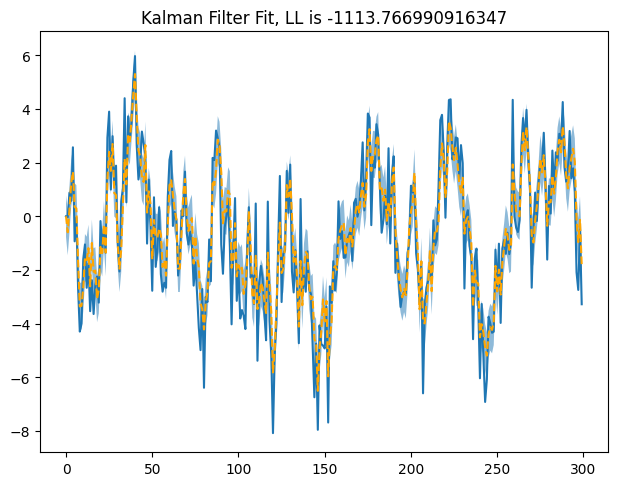

In [6]:
'''Implementation of the Kalman Filter'''

posterior_mean = np.zeros(T)
posterior_cov = np.zeros(T)

posterior_mean[0] = 0
posterior_cov[0] = 1

LL = np.zeros(T)

for time_index in range(len(Y)):

    '''Forecast'''
    if(time_index > 0):
        posterior_mean[time_index] = model_params['rho'] * posterior_mean[time_index-1] + rng.normal(0,model_params['sigma_x'])
        posterior_cov[time_index] = model_params['rho'] * posterior_cov[time_index-1] * model_params['rho'] + model_params['sigma_x']**2

    '''Likelihood'''
    LL[time_index] = norm.logpdf(x = Y[i], loc = posterior_mean[time_index],scale = np.sqrt(posterior_cov[time_index] + model_params['sigma_y']**2))

    '''Update'''
    K = posterior_cov[time_index] / (posterior_cov[time_index] + model_params['sigma_y']**2)

    posterior_mean[time_index] = posterior_mean[time_index] + K * (Y[time_index] - posterior_mean[time_index])
    posterior_cov[time_index] = (1 - K) * posterior_cov[time_index]

fig, ax = plt.subplots(1, sharex=True)
fig.tight_layout()  
ax.set_title(f'Kalman Filter Fit, LL is {np.sum(LL)}')
ax.plot(Y)
ax.plot(posterior_mean,'--',color = 'orange',zorder = 12)
ax.fill_between(np.arange(0,T), posterior_mean - np.sqrt(posterior_cov),posterior_mean + np.sqrt(posterior_cov),alpha = 0.5)

In [7]:
'''Running PMMH to estimate the model parameters'''

prior = lambda x: uniform.logpdf(x[0],-1,2) + gamma.logpdf(x = np.exp(x[1]),a = 2. , scale = 1/2) + gamma.logpdf(x = np.exp(x[2]),a = 2. , scale = 1/2) + x[1] + x[2]

theta, LL = PMCMC(iterations=1000,
                  num_particles=1000,
                  init_theta=np.array([rng.uniform(-1,1),rng.gamma(2,2),rng.gamma(2,2)]),
                  data = Y,
                  rng = rng,
                  dt = 1, 
                  prior = prior, 
                  model = AR_PMCMC_model,
                  model_dim=1)


[[0.47098063 0.01249707 0.06747961]
 [0.01249707 0.51278937 0.24438445]
 [0.06747961 0.24438445 1.78711657]]
[[0.4558401  0.00228318 0.01232835]
 [0.01436178 0.48309971 0.04464842]
 [0.07754838 0.26943006 1.09635789]]
[[0.56107465 0.00864784 0.05981229]
 [0.02515434 0.54111083 0.01391893]
 [0.1489414  0.31213293 0.8468018 ]]
[[0.64985668 0.00290082 0.02006335]
 [0.03147662 0.62597141 0.00466895]
 [0.18926357 0.35838414 0.71009505]]
[[ 0.72974339 -0.00290183 -0.00642024]
 [ 0.03244068  0.83080841  0.25564208]
 [ 0.20608823  0.65564721  1.17928675]]
[[ 0.80864134 -0.00125539 -0.00277753]
 [ 0.03469129  0.91202672  0.11059601]
 [ 0.22558352  0.78255007  0.98831071]]
[[ 0.98687343 -0.03216607 -0.17176817]
 [ 0.00562089  0.94440339  0.05208773]
 [ 0.07394527  0.84542553  0.7865047 ]]
[[ 1.05280499 -0.01607779 -0.08585606]
 [-0.01038335  0.98289525  0.02603537]
 [-0.01094328  0.90114761  0.29774766]]
[[ 1.05684461 -0.00846285 -0.04519197]
 [-0.00846285  1.03150323  0.01370421]
 [-0.04519197 

c:\Users\avery\Avery's Work\PMCMC\pmcmc.py:42: RuntimeWarning: divide by zero encountered in log
  LL_new = np.sum(np.log(likelihood))


[[ 1.19716331e+00 -5.82353449e-04 -3.10979205e-03]
 [-2.02692466e-02  1.18957579e+00  9.43026999e-04]
 [-1.08238634e-01  2.79130572e-02  1.20149936e+00]]
[[ 1.21982455e+00 -3.68055595e-04 -1.96543244e-03]
 [-2.10004314e-02  1.21467934e+00  5.96006366e-04]
 [-1.12143192e-01  2.72320803e-02  1.21872470e+00]]
[[ 1.24114330e+00 -2.37073270e-04 -1.26598129e-03]
 [-2.15910677e-02  1.23763050e+00  3.83901726e-04]
 [-1.15297215e-01  2.61695747e-02  1.23632776e+00]]
[[ 1.26109460e+00 -1.55337495e-04 -8.29508793e-04]
 [-2.20845691e-02  1.25865325e+00  2.51543889e-04]
 [-1.17932533e-01  2.48323898e-02  1.25377491e+00]]
[[ 1.27971007e+00 -1.03371088e-04 -5.52005983e-04]
 [-2.25079689e-02  1.27796519e+00  1.67392719e-04]
 [-1.20193506e-01  2.32903835e-02  1.27071138e+00]]
[[ 1.29809039  0.00674276 -0.01103507]
 [-0.01606629  1.33177293 -0.05896532]
 [-0.13283638 -0.03748769  1.38283021]]
iteration: 20| Acceptance rate: 0.2| Log-Likelihood: -621.6939325397971
[[ 1.31445618  0.00461008 -0.00754477]
 

SystemError: CPUDispatcher(<function filter at 0x000001D3642ACA40>) returned a result with an exception set

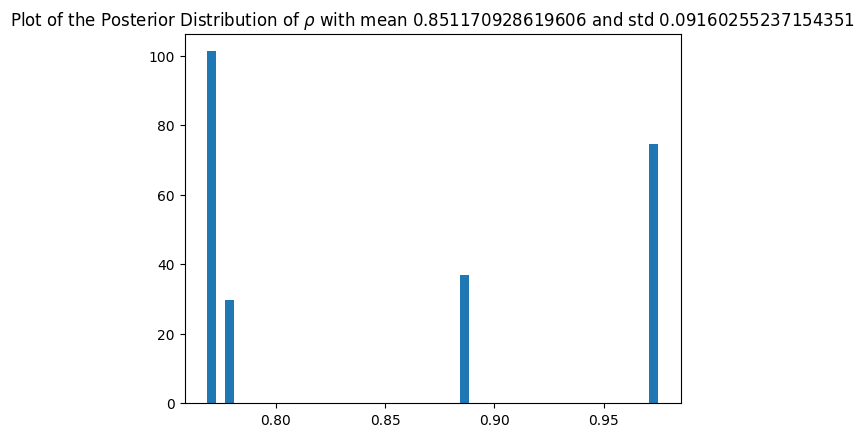

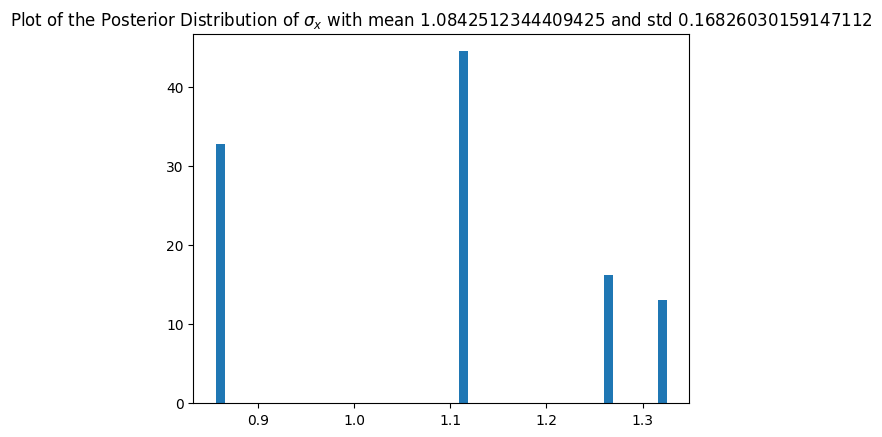

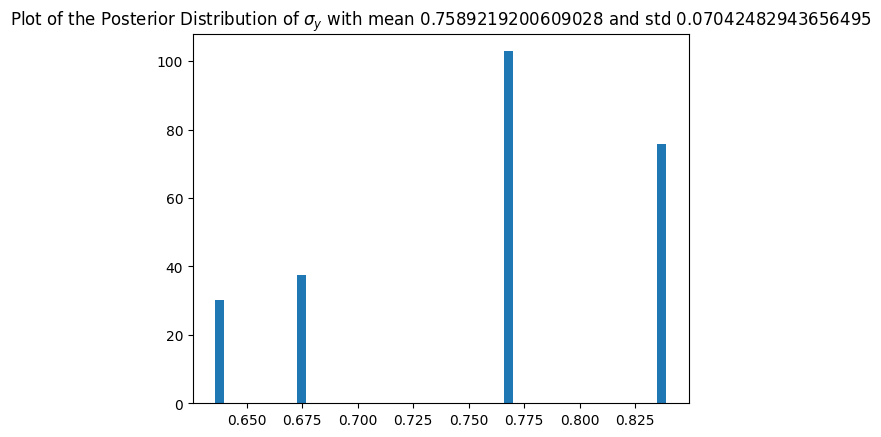

In [ ]:
burn_in = 100
plt.title(f'Plot of the Posterior Distribution of $\\rho$ with mean {np.mean(theta[0,burn_in:])} and std {np.std(theta[0,burn_in:])}')
plt.hist(theta[0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f'Plot of the Posterior Distribution of $\\sigma_x$ with mean {np.mean(np.exp(theta[1,burn_in:]))} and std {np.std(np.exp(theta[1,burn_in:]))}')
plt.hist(np.exp(theta[1,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f'Plot of the Posterior Distribution of $\\sigma_y$ with mean {np.mean(np.exp(theta[2,burn_in:]))} and std {np.std(np.exp(theta[2,burn_in:]))}')
plt.hist(np.exp(theta[2,burn_in:]),density=True,bins = 50)
plt.show()